In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt


In [66]:

output_dir = "../../1_snakemake/outputs"
input_dir = "../../1_snakemake/inputs"

cmpds = [
    "Tolcapone",
    "Benzarone",
    "Tiratricol",
    "2-Ethylanthracene-9,10-dione"
]

def Exp2(b, e, dose):
    return e * np.exp(b * dose)

def Exp3(b, c, d, e, dose):
    return e * (np.exp(np.sign(b) * (np.abs(b) * dose)**d))

def Exp4(b, c, e, dose):
    return e * (c - (c - 1) * np.exp(-b * dose))

def Exp5(b, c, d, e, dose):
    return e * (c - (c - 1) * np.exp(- (b * dose)**d))

def Hill(b, c, d, e, dose):
    return c + (d - c) / (1 + (dose / e)**b)

def Pow(b, c, e, dose):
    return e + b * (dose**c)

def Poly2(b, c, d, dose):
    return b + c * dose + d * dose**2

def Lin(b, d, dose):
    return d + b * dose

In [99]:
dat = pl.read_parquet(f"{output_dir}/cellprofiler/mad_featselect/profiles/mad_featselect.parquet")
meta_cols = [i for i in dat.columns if "Metadata_" in i]
dat = dat.select(meta_cols)

mt_curves = pl.read_parquet(f"{output_dir}/cellprofiler/mad_featselect/curves/mttpods.parquet")

dat_dmso = dat.filter(pl.col("Metadata_Compound") == "DMSO").sample(n=100, with_replacement=False, seed=100)
dat_dmso = dat_dmso.with_columns(
    (pl.col("Metadata_Concentration") + 0.015).alias("Metadata_Concentration")
)
dat = dat.filter(pl.col("Metadata_Compound").is_in(cmpds))
mt_curves = mt_curves.filter(pl.col("Metadata_Compound").is_in(cmpds))

In [100]:
conc_conv = pl.read_parquet(f"{input_dir}/metadata/metadata.parquet")
conc_conv = conc_conv.filter(pl.col("Metadata_Compound") != "DMSO").select(
    ["Metadata_Compound", "Metadata_Concentration"]
).group_by("Metadata_Compound").agg([
    pl.col("Metadata_Concentration").min().alias("Metadata_Min_Conc")
])

conc_conv = conc_conv.with_columns(
    (pl.col("Metadata_Min_Conc")/3).log10().abs().alias("Metadata_Conc_Shift")
)

mt_curves = mt_curves.join(conc_conv, on="Metadata_Compound")

mt_curves = mt_curves.with_columns(
    (10 ** (pl.col("bmd") - pl.col("Metadata_Conc_Shift"))).alias("bmd_um")
)

In [112]:
def plot_compound(compound):
    highest_dose = dat.filter(pl.col("Metadata_Compound") == compound)['Metadata_Log10Conc'].max() * 1.025

    log_dose = np.logspace(-7, -1, num=7, base=10)
    lin_dose = np.arange(0.1, highest_dose, 0.1)
    dose = np.concatenate([log_dose, lin_dose])

    dat_compound = dat.filter(pl.col("Metadata_Compound") == compound)
    dat_compound = pl.concat([dat_compound, dat_dmso])
    pod_compound = mt_curves.filter(pl.col("Metadata_Compound") == compound)

    model = pod_compound['mod.name'][0]
    params = pod_compound.select(['b', 'c', 'd', 'e', 'f']).to_numpy()[0]
    shift = pod_compound['Metadata_Conc_Shift'][0]
    
    # Compute model predictions
    if model == "Exp2": # b, e
        predictions = Exp2(params[0], params[3], dose)
    elif model == "Exp3": # b, c, d, e
        predictions = Exp3(params[0], params[1], params[2], params[3], dose)
    elif mode == "Exp4": # b, c, e
        predictions = Exp4(params[0], params[1], params[3], dose)
    elif mode == "Exp5": # b, c, d, e
        predictions = Exp5(params[0], params[1], params[2], params[3], dose)
    elif mode == "Hill": # b, c, d, e
        predictions = Hill(params[0], params[1], params[2], params[3], dose)
    elif mode == "Pow": # b, c, e
        predictions = Pow(params[0], params[1], params[3], dose)
    elif mode == "Poly2": # b, c, d
        predictions = Poly2(params[0], params[1], params[2], dose)
    elif mode == "Lin": # b, d
        predictions = Lin(params[0], params[2], dose)

    plot_data = pl.DataFrame({
        'Dose': dose,
        'Predictions': predictions
    })

    plot_data = plot_data.with_columns(
        (10 ** (pl.col("Dose") - shift)).alias("Dose_um")
    )

    from plotnine import ggplot, aes, geom_point, geom_line, geom_vline, theme_classic, labs, facet_wrap, scale_x_log10, theme, element_text, ylim, element_blank
    import plotnine as pn

    pn.options.figure_size = (4, 3)

    custom_breaks = [0.015, 0.1, 1, 10, 100]
    custom_labels = ["DMSO", "0.1", "1", "10", "100"]

    plt = (
        ggplot(plot_data, aes('Dose_um', 'Predictions'))
        + geom_line(size=1)
        + geom_point(data=dat_compound, mapping=aes('Metadata_Concentration', 'Metadata_mtt_normalized'), size=2)
        + geom_vline(xintercept=pod_compound['bmd_um'][0], linetype="dashed", color="blue", size=1)
        + ylim(0.7, 1.7)
        + theme_classic()
        + labs(title = compound, x="Concentration (µM)")
        + scale_x_log10(breaks=custom_breaks, labels=custom_labels)
        + theme(
            title = element_text(size=14, color='black', weight='bold', family='Arial'),
            axis_text_x=element_text(angle=45, hjust=1, color='black', size=12, family='Arial'),
            axis_text_y=element_text(color='black', size=12, family='Arial'),
            axis_title_x=element_blank(),
            axis_title_y=element_blank()
        )
    )
    plt.show()

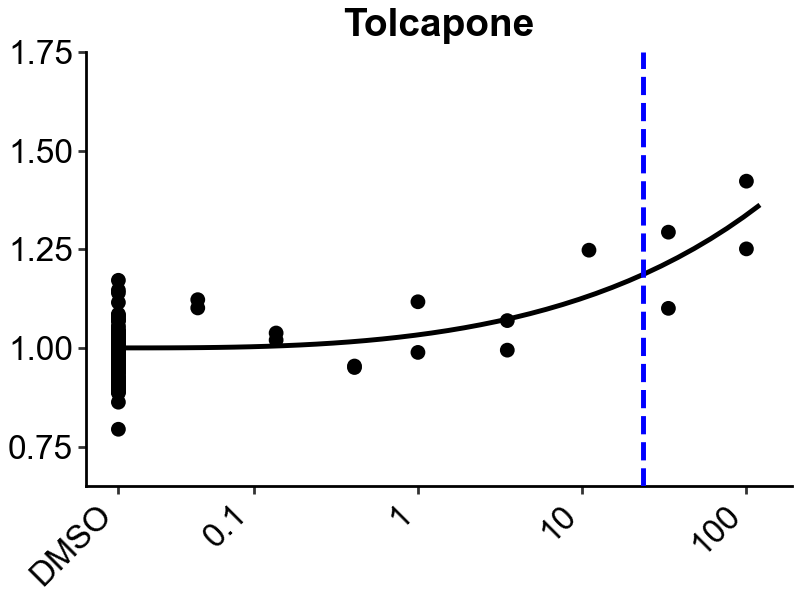

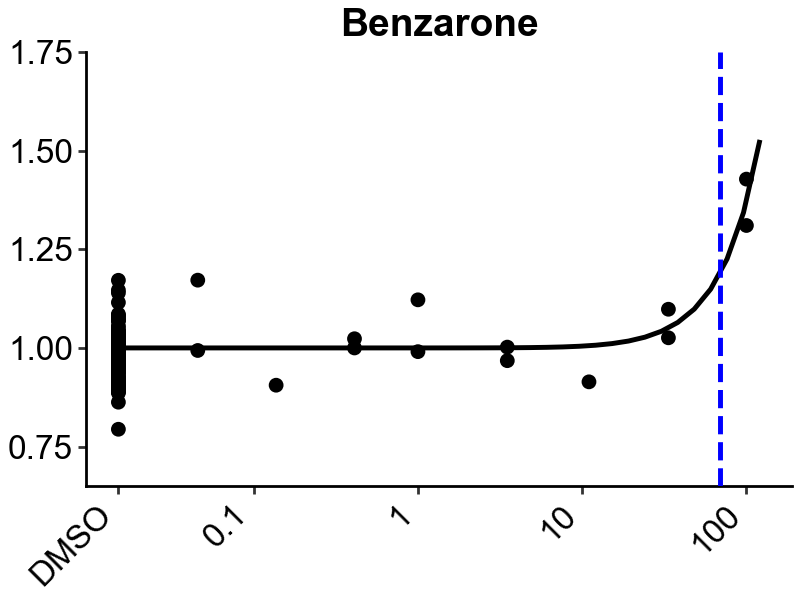

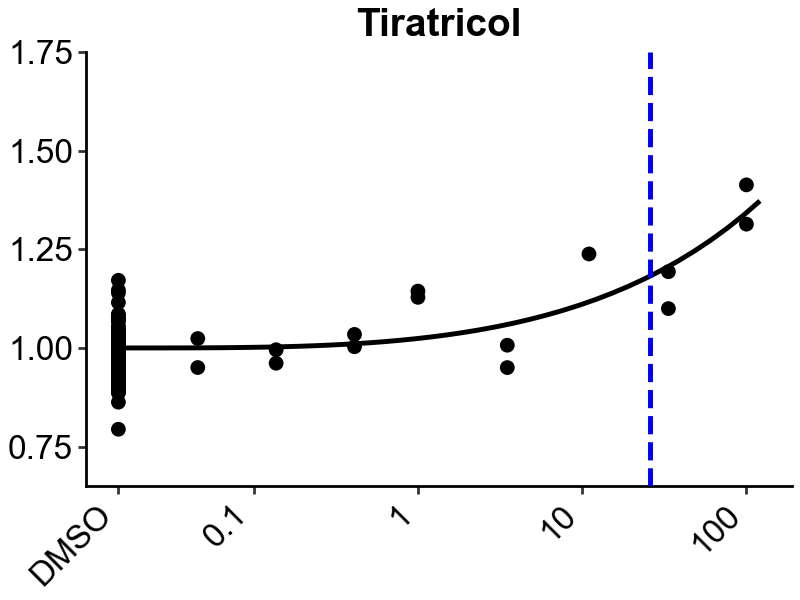

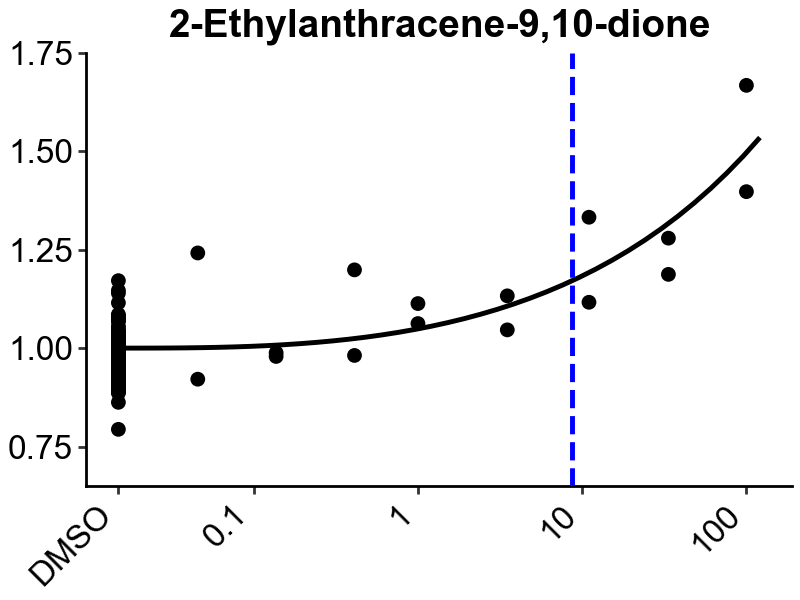

In [113]:
for cmpd in cmpds:
    plot_compound(cmpd)